# LSTM
Long-short term memory - RNN

---

## Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

## Fetching data
We are fetching data from [yahoo api](https://developer.yahoo.com/api/).

In [14]:
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2016, 1, 1)
end = dt.datetime.now()

data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

## Prepare Data
Spliting data into two variables. X and Y to train the model.
Scaled data is split at prediction_days value.
The we reshape both variables to fit correct dimension with lstm. (3dim)

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 400

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Create Neural Network Model
Creating 3 rows of 50 units.
Adding dropout to regularisation.
Dense module to connect all nodes to an end (output).

In [22]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
57/57 [==============================] - 33s 483ms/step - loss: 0.0094
Epoch 2/25
57/57 [==============================] - 28s 486ms/step - loss: 0.0034
Epoch 3/25
57/57 [==============================] - 26s 463ms/step - loss: 0.0027
Epoch 4/25
57/57 [==============================] - 27s 477ms/step - loss: 0.0024
Epoch 5/25
57/57 [==============================] - 27s 477ms/step - loss: 0.0022
Epoch 6/25
57/57 [==============================] - 27s 472ms/step - loss: 0.0022
Epoch 7/25
57/57 [==============================] - 27s 476ms/step - loss: 0.0020
Epoch 8/25
57/57 [==============================] - 26s 457ms/step - loss: 0.0024
Epoch 9/25
57/57 [==============================] - 26s 457ms/step - loss: 0.0020
Epoch 10/25
57/57 [==============================] - 27s 473ms/step - loss: 0.0017
Epoch 11/25
57/57 [==============================] - 27s 469ms/step - loss: 0.0017
Epoch 12/25
57/57 [==============================] - 27s 475ms/step - loss: 0.0018
Epoch 13/25
5

## Testing The Model
Fetching data to test our model (ie: 2020,1,1 to now)
Sanitize useless features provided. (only Close is needed)
Transform values to an relative intervalle between 0 and 1. (needed by the model)

In [23]:
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

### Predicting On Test Model
Using the model and ploting prediction above real values.

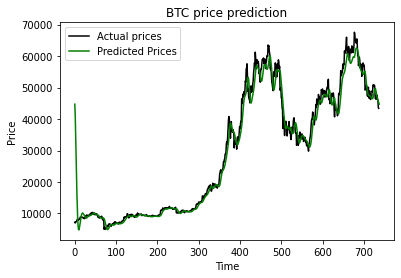

In [24]:
x_test = []

for x in range(prediction_days, len(model_inputs) + 1):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.plot(actual_prices, color='black', label='Actual prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

## Predicting The Future

### Only one value
We are taking values out of fetched data. Predicting one value is realistic.

In [25]:
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction : {prediction}")


Prediction : [[44720.543]]


### Multiple row *(failed)*
The idea was to loop through predicting, feed by his own prediction. However the model failed but we don't now why.

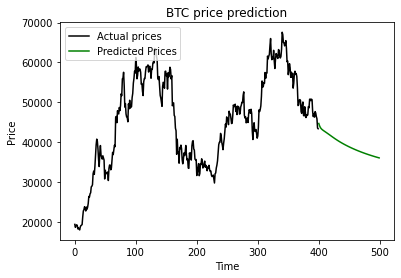

In [26]:
future_days = 100

base_values = real_data[0]
predicted_values = []


for i in range(0, future_days):
    value = model.predict(np.array([base_values]))
    base_values = np.append(base_values, value, axis=0)
    predicted_values.append(scaler.inverse_transform(value)[0][0])
    base_values = base_values[1:]


graph = scaler.inverse_transform(real_data[0])

x_axe = []
for j in range(len(real_data[0]),len(real_data[0])+future_days):
    x_axe.append(j)

plt.plot(graph, color='black', label='Actual prices')
plt.plot(x_axe, predicted_values, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()